<a href="https://colab.research.google.com/github/AndikaElang/Covid19-Detection/blob/main/COVID_19_Detection_CNN_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install niapy

In [ ]:
pip install niapy # Selalu jalankan code program

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 4.7 MB/s 


### Colab GPU and memory setting

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun 14 04:01:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Import library

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob
import cv2
import pickle

import tensorflow as tf
from numpy.random import seed
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from niapy.task import Task, OptimizationType
from niapy.problems import Problem
from niapy.algorithms.algorithm import Algorithm
from niapy.util.repair import reflect
from niapy.algorithms.basic import ParticleSwarmAlgorithm

### Split dataset and define classes

In [ ]:
path = 'COVID-19_Radiography_Dataset/' # sesuain

batch_size = 32 # gausah peduliin dulu
classes = ['COVID', 'Normal'] # sesuain
num_classes = len(classes)
print("Number of Classes:", num_classes)

Number of Classes: 2


In [ ]:
# This code is only run once

val_ratio = 0.20
test_ratio = 0.20

for cls in classes:
    os.makedirs(path +'train/' + cls)
    os.makedirs(path +'validation/' + cls)
    os.makedirs(path +'test/' + cls)
    
    src = path + cls

    datagen = os.listdir(src)
    np.random.shuffle(datagen)
    data_train, data_val, data_test = np.split(np.array(datagen),
                                                          [int(len(datagen)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(datagen)* (1 - test_ratio))])
    
    data_train = [src+'/'+ name for name in data_train.tolist()]
    data_val = [src+'/'+ name for name in data_val.tolist()]
    data_test = [src+'/'+ name for name in data_test.tolist()]
    
    print('Total Images', cls, ':', len(datagen))
    print('Total Traning Images', cls, ':', len(data_train))
    print('Total Validation Images', cls, ':', len(data_val))
    print('Total Test Images', cls, ':', len(data_test), '\n')
    
    for name in data_train:
        shutil.copy(name, path +'train/' + cls)
       
    for name in data_val:
        shutil.copy(name, path +'validation/' + cls)

    for name in data_test:
        shutil.copy(name, path +'test/' + cls)

### Load splitted dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/TA/COVID-19_Radiography_Dataset.zip' -d ''

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: train/Normal/Normal-6633.png  
  inflating: train/Normal/Normal-6634.png  
  inflating: train/Normal/Normal-6637.png  
  inflating: train/Normal/Normal-6641.png  
  inflating: train/Normal/Normal-6643.png  
  inflating: train/Normal/Normal-6645.png  
  inflating: train/Normal/Normal-6646.png  
  inflating: train/Normal/Normal-6649.png  
  inflating: train/Normal/Normal-665.png  
  inflating: train/Normal/Normal-6650.png  
  inflating: train/Normal/Normal-6651.png  
  inflating: train/Normal/Normal-6652.png  
  inflating: train/Normal/Normal-6655.png  
  inflating: train/Normal/Normal-6656.png  
  inflating: train/Normal/Normal-6657.png  
  inflating: train/Normal/Normal-6659.png  
  inflating: train/Normal/Normal-666.png  
  inflating: train/Normal/Normal-6661.png  
  inflating: train/Normal/Normal-6664.png  
  inflating: train/Normal/Normal-6665.png  
  inflating: train/Normal/Normal-6669.png  
  inflating: train/

In [ ]:
data = "/content/"
train = 'train/'
val = 'validation/'
test = 'test/'

### Preprocessing data (ImageDataGenerator)

In [ ]:
# buat training model

dataset = ImageDataGenerator(rotation_range=10, 
                             zoom_range=0.2,
                             shear_range=0.2,
                             rescale=1./255)

train_data = dataset.flow_from_directory(data+train, 
                                         target_size=(150, 150),
                                         class_mode='binary',
                                         batch_size=batch_size,
                                         shuffle=True)

val_data = dataset.flow_from_directory(data+val, 
                                       target_size=(150, 150),
                                       class_mode='binary',
                                       batch_size=batch_size,
                                       shuffle=True)

Found 8284 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


### visualize x-ray Images

In [ ]:
train_data.class_indices

{'COVID': 0, 'Normal': 1}

In [ ]:
X_train, y_train = train_data.next()
X_val, y_val = val_data.next()

In [ ]:
labels = ['Normal' if label == 1 else 'Covid-19' for label in y_train]

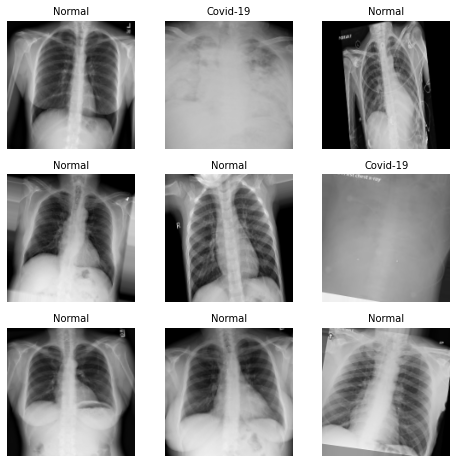

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap='cool')
    plt.title(labels[i],  fontsize=10,)
    plt.axis('off')

### CNN Architecture

#### CNN model

In [ ]:
def model_cnn(param_):
  seed(8)
  tf.random.set_seed(8)
  model = Sequential()
    
  model.add(Conv2D(filters=param_['fil1'], kernel_size=(param_['ker_size'], param_['ker_size']), activation=param_['conv_act'], padding='same', input_shape=(150,150,3)))
  if (param_['pool'] == 'max'):
    model.add(MaxPooling2D(pool_size=(param_['pool_size'], param_['pool_size'])))
  else:
    model.add(AveragePooling2D(pool_size=(param_['pool_size'], param_['pool_size'])))
            
  for i in range(param_['conv_layer']-1):
    model.add(Conv2D(filters=param_['fil'+str(i+2)], kernel_size=(param_['ker_size'], param_['ker_size']), activation=param_['conv_act'], padding='same'))
    if (param_['pool'] == 'max'):
      model.add(MaxPooling2D(pool_size=(param_['pool_size'], param_['pool_size'])))
    else:
      model.add(AveragePooling2D(pool_size=(param_['pool_size'], param_['pool_size'])))
    
  model.add(Flatten())
  model.add(Dense(units=param_['dense_unit'], activation=param_['conv_act']))
  model.add(Dropout(param_['drop_rate']))
  model.add(Dense(1, activation='sigmoid'))
    
  model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
  return model

#### Choose Parameter

In [ ]:
def get_hyperparameter(x):
  # Number of Convolution Layers
  conv_layers = (2, 3, 4)

  # Convolution Layer
  filters = (32, 64, 96, 128, 168, 192, 224, 256)
  ker_sizes = (3, 5, 7)

  # Dense Unit
  dense_units = (128, 256, 512)

  # Dropout Rate
  drop_rates = (0.1, 0.2, 0.3, 0.4, 0.5)
    
  # Choose Number of Conv Layers
  conv_layer = conv_layers[int(x[0] * 2)]

  # Choose Conv Filter
  fil1 = filters[int(x[1] * 7)]
  fil2 = filters[int(x[2] * 7)]
  fil3 = filters[int(x[3] * 7)]
  fil4 = filters[int(x[4] * 7)]

  # Choose Kernel Size
  ker_size = ker_sizes[int(x[5] * 2)]
  
  # Choose Activation Function Relu and Tanh
  conv_act = 'relu' if x[6] < 0.5 else 'tanh'
    
  # Choose Pooling Type Max and Avg
  pool = 'max' if x[7] < 0.5 else 'avg'
    
  # Choose Pooling Size 2 and 3
  pool_size = 2 if x[8] < 0.5 else 3
    
  # Choose Number of Dense Units
  dense_unit = dense_units[int(x[9] * 2)]
    
  # Choose Dropout Rate
  drop_rate = drop_rates[int(x[10] * 4)]
    
  params = {'conv_layer' : conv_layer,
            'fil1' : fil1,
            'fil2' : fil2,
            'fil3' : fil3,
            'fil4' : fil4,
            'ker_size' : ker_size,
            'conv_act' : conv_act,
            'pool' : pool,
            'pool_size' : pool_size,
            'dense_unit' : dense_unit,
            'drop_rate' : drop_rate}
    
  return params

### Define Model & Problem

In [ ]:
def get_model(x):
  params = get_hyperparameter(x)
  print("=-----="*10)
  print("Parameters")
  print(params)
  return model_cnn(params)

In [ ]:
def model_fit(model, train_data, val_data):
  callbacks = EarlyStopping(monitor = 'val_loss', patience=3, verbose=2, mode="min")
  history = model.fit(train_data,
                      steps_per_epoch=train_data.samples//batch_size,
                      validation_steps=val_data.samples//batch_size,
                      epochs=10,
                      validation_data=val_data,
                      verbose=2,
                      callbacks=[callbacks])
  return history, model

In [ ]:
class CNNHyperParameterOptimization(Problem):
  def __init__(self, train_data, val_data):
    super().__init__(dimension=11, lower=0, upper=1)
    self.train_data = train_data
    self.val_data = val_data
    
  def _evaluate(self, x):
    model = get_model(x)
    history, model = model_fit(model, train_data, val_data)
    return history.history['val_accuracy'][-1]

#### Baseline CNN Model

In [ ]:
params = {'conv_layer' : 1,
          'fil1' : 32,
          'ker_size' : 3,
          'conv_act' : 'relu',
          'pool' : 'max',
          'pool_size' : 2,
          'dense_unit' : 128,
          'drop_rate' : 0.1}

baseline_model = model_cnn(params)
baseline_history, baseline_model = model_fit(baseline_model, train_data, val_data)

Epoch 1/10
258/258 - 82s - loss: 0.6575 - accuracy: 0.7519 - val_loss: 0.4550 - val_accuracy: 0.7860 - 82s/epoch - 317ms/step
Epoch 2/10
258/258 - 70s - loss: 0.4529 - accuracy: 0.7873 - val_loss: 0.4258 - val_accuracy: 0.8081 - 70s/epoch - 272ms/step
Epoch 3/10
258/258 - 70s - loss: 0.4258 - accuracy: 0.7996 - val_loss: 0.4002 - val_accuracy: 0.8147 - 70s/epoch - 273ms/step
Epoch 4/10
258/258 - 73s - loss: 0.4003 - accuracy: 0.8152 - val_loss: 0.3714 - val_accuracy: 0.8408 - 73s/epoch - 284ms/step
Epoch 5/10
258/258 - 70s - loss: 0.3900 - accuracy: 0.8232 - val_loss: 0.3920 - val_accuracy: 0.8299 - 70s/epoch - 273ms/step
Epoch 6/10
258/258 - 70s - loss: 0.3685 - accuracy: 0.8322 - val_loss: 0.3528 - val_accuracy: 0.8576 - 70s/epoch - 270ms/step
Epoch 7/10
258/258 - 73s - loss: 0.3503 - accuracy: 0.8417 - val_loss: 0.3325 - val_accuracy: 0.8583 - 73s/epoch - 281ms/step
Epoch 8/10
258/258 - 69s - loss: 0.3390 - accuracy: 0.8480 - val_loss: 0.3243 - val_accuracy: 0.8561 - 69s/epoch - 269

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 180000)            0         
                                                                 
 dense (Dense)               (None, 128)               23040128  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

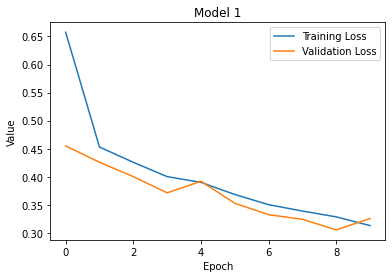

In [ ]:
#Baseline Model loss train & validation
plt.plot(baseline_history.history['loss'], label='Training Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Model 1')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

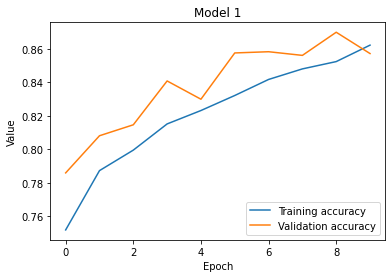

In [ ]:
#Best Model 1 acurracy train & validation
plt.plot(baseline_history.history['accuracy'], label='Training accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model 1')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Saving baseline model and history
baseline_model.save("baseline_model.h5")
with open('history_params_baseline.pkl', 'wb') as f:
    pickle.dump([baseline_history.history, params], f)
print("Save Success")

Save Success


#### PSO Parameters

In [ ]:
weight = [0.9, 0.7, 0.5]
constant1 = [0.3, 0.5]
constant2 = [0.3, 0.5]

#### PSO Optimization and Fitting

In [ ]:
def particleSwarmOptimization(train_data, val_data, w, c1, c2):  
  problem = CNNHyperParameterOptimization(train_data, val_data)
  task = Task(problem=problem, max_iters=8, optimization_type=OptimizationType.MAXIMIZATION)
  algo = ParticleSwarmAlgorithm(population_size=10, w=w, c1=c1, c2=c2, min_velocity=-1, max_velocity=1)

  best_params, best_accuracy = algo.run(task)
  best_params = get_hyperparameter(best_params)
  print("=-----="*5 + " Fitting Best Parameterss " + "=-----="*5)
  print(best_params)
  model = model_cnn(best_params)
  history, best_model = model_fit(model, train_data, val_data)
  
  return best_params, history, best_model, task

### Train Model

#### PSO Weight: 0.9, Constant 1: 0.5, Constant 2: 0.3

In [ ]:
print("Weight : {}".format(weight[0]) + ", Constant 1 : {}".format(constant1[1]) + ", Constant 2 : {}".format(constant2[0]))

Weight : 0.9, Constant 1 : 0.5, Constant 2 : 0.3


In [ ]:
best_params_1, history_1, best_model_1, task_1 = particleSwarmOptimization(train_data, val_data, weight[0], constant1[1], constant2[0])

=-----==-----==-----==-----==-----==-----==-----==-----==-----==-----=
Parameters
{'conv_layer': 2, 'fil1': 168, 'fil2': 168, 'fil3': 224, 'fil4': 224, 'ker_size': 5, 'conv_act': 'relu', 'pool': 'max', 'pool_size': 3, 'dense_unit': 256, 'drop_rate': 0.1}
Epoch 1/10
258/258 - 72s - loss: 0.5057 - accuracy: 0.7540 - val_loss: 0.4107 - val_accuracy: 0.8096 - 72s/epoch - 281ms/step
Epoch 2/10
258/258 - 69s - loss: 0.4182 - accuracy: 0.7986 - val_loss: 0.3731 - val_accuracy: 0.8318 - 69s/epoch - 269ms/step
Epoch 3/10
258/258 - 69s - loss: 0.3631 - accuracy: 0.8320 - val_loss: 0.3359 - val_accuracy: 0.8441 - 69s/epoch - 268ms/step
Epoch 4/10
258/258 - 69s - loss: 0.3153 - accuracy: 0.8572 - val_loss: 0.2869 - val_accuracy: 0.8732 - 69s/epoch - 267ms/step
Epoch 5/10
258/258 - 69s - loss: 0.2873 - accuracy: 0.8697 - val_loss: 0.2840 - val_accuracy: 0.8844 - 69s/epoch - 266ms/step
Epoch 6/10
258/258 - 69s - loss: 0.2694 - accuracy: 0.8828 - val_loss: 0.2467 - val_accuracy: 0.8946 - 69s/epoch - 

In [ ]:
best_model_1.summary()

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_262 (Conv2D)         (None, 150, 150, 96)      2688      
                                                                 
 max_pooling2d_241 (MaxPooli  (None, 50, 50, 96)       0         
 ng2D)                                                           
                                                                 
 conv2d_263 (Conv2D)         (None, 50, 50, 168)       145320    
                                                                 
 max_pooling2d_242 (MaxPooli  (None, 16, 16, 168)      0         
 ng2D)                                                           
                                                                 
 conv2d_264 (Conv2D)         (None, 16, 16, 168)       254184    
                                                                 
 max_pooling2d_243 (MaxPooli  (None, 5, 5, 168)      

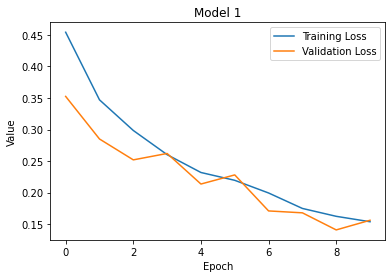

In [ ]:
#Best Model 1 loss train & validation
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model 1')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

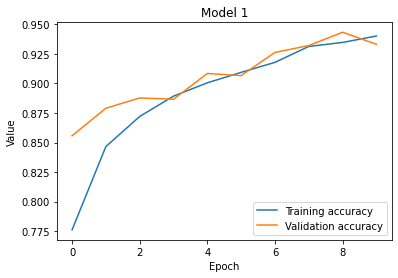

In [ ]:
#Best Model 1 acurracy train & validation
plt.plot(history_1.history['accuracy'], label='Training accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation accuracy')
plt.title('Model 1')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:
task_1.convergence_data()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([0.93786335, 0.93786335, 0.93895346, 0.94331396, 0.94367731,
        0.94367731, 0.94767439, 0.94840115]))

In [ ]:
iter, fitness_1 = task_1.convergence_data()

In [ ]:
fitness_1

array([0.93786335, 0.93786335, 0.93895346, 0.94331396, 0.94367731,
       0.94367731, 0.94767439, 0.94840115])

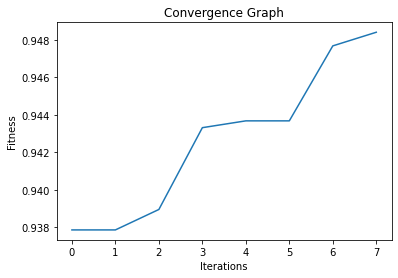

In [ ]:
task_1.plot_convergence()

In [ ]:
#Saving best model 1 and history
best_model_1.save("best_model_1.h5")
with open('history_params_fitness_1.pkl', 'wb') as f:
    pickle.dump([history_1.history, best_params_1, fitness_1], f)
print("Save Success")

Save Success


#### PSO Weight: 0.7, Constant 1: 0.5, Constant 2: 0.3

In [ ]:
print("Weight : {}".format(weight[1]) + ", Constant 1 : {}".format(constant1[1]) + ", Constant 2 : {}".format(constant2[0]))

Weight : 0.7, Constant 1 : 0.5, Constant 2 : 0.3


In [ ]:
best_params_2, history_2, best_model_2, task_2 = particleSwarmOptimization(train_data, val_data, weight[1], constant1[1], constant2[0])

=-----==-----==-----==-----==-----==-----==-----==-----==-----==-----=
Parameters
{'conv_layer': 3, 'fil1': 168, 'fil2': 32, 'fil3': 168, 'fil4': 192, 'ker_size': 3, 'conv_act': 'tanh', 'pool': 'avg', 'pool_size': 2, 'dense_unit': 128, 'drop_rate': 0.3}
Epoch 1/10
258/258 - 85s - loss: 2.2529 - accuracy: 0.5364 - val_loss: 0.5748 - val_accuracy: 0.7384 - 85s/epoch - 328ms/step
Epoch 2/10
258/258 - 70s - loss: 0.5981 - accuracy: 0.7332 - val_loss: 0.5767 - val_accuracy: 0.7376 - 70s/epoch - 273ms/step
Epoch 3/10
258/258 - 70s - loss: 0.5884 - accuracy: 0.7350 - val_loss: 0.5755 - val_accuracy: 0.7380 - 70s/epoch - 271ms/step
Epoch 4/10
258/258 - 70s - loss: 0.5914 - accuracy: 0.7357 - val_loss: 0.5748 - val_accuracy: 0.7384 - 70s/epoch - 271ms/step
Epoch 4: early stopping
=-----==-----==-----==-----==-----==-----==-----==-----==-----==-----=
Parameters
{'conv_layer': 3, 'fil1': 224, 'fil2': 32, 'fil3': 128, 'fil4': 168, 'ker_size': 3, 'conv_act': 'tanh', 'pool': 'max', 'pool_size': 3, '

In [ ]:
best_model_2.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_246 (Conv2D)         (None, 150, 150, 224)     6272      
                                                                 
 max_pooling2d_225 (MaxPooli  (None, 50, 50, 224)      0         
 ng2D)                                                           
                                                                 
 conv2d_247 (Conv2D)         (None, 50, 50, 128)       258176    
                                                                 
 max_pooling2d_226 (MaxPooli  (None, 16, 16, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_248 (Conv2D)         (None, 16, 16, 96)        110688    
                                                                 
 max_pooling2d_227 (MaxPooli  (None, 5, 5, 96)       

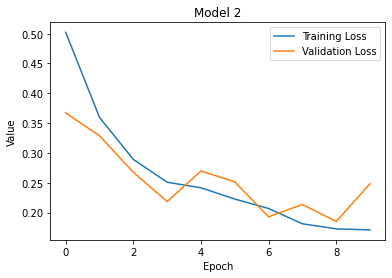

In [ ]:
#Best Model 2 loss train & validation
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model 2')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

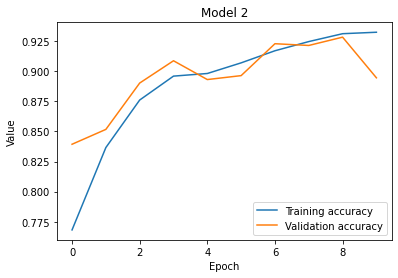

In [ ]:
#Best Model 2 acurracy train & validation
plt.plot(history_2.history['accuracy'], label='Training accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation accuracy')
plt.title('Model 2')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:
task_2.convergence_data()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([0.94040698, 0.94040698, 0.94040698, 0.94040698, 0.94040698,
        0.94040698, 0.94040698, 0.94295061]))

In [ ]:
iter, fitness_2 = task_2.convergence_data()

In [ ]:
fitness_2

array([0.94040698, 0.94040698, 0.94040698, 0.94040698, 0.94040698,
       0.94040698, 0.94040698, 0.94295061])

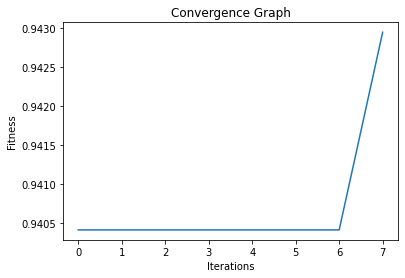

In [ ]:
task_2.plot_convergence()

In [ ]:
#Saving best model 2 and history
best_model_2.save("best_model_2.h5")
with open('history_params_fitness_2.pkl', 'wb') as f:
    pickle.dump([history_2.history, best_params_2, fitness_2], f)
print("Save Success")

Save Success


#### PSO Weight: 0.5, Constant 1: 0.5, Constant 2: 0.3

In [ ]:
print("Weight : {}".format(weight[2]) + ", Constant 1 : {}".format(constant1[1]) + ", Constant 2 : {}".format(constant2[0]))

Weight : 0.5, Constant 1 : 0.5, Constant 2 : 0.3


In [ ]:
best_params_3, history_3, best_model_3, task_3 = particleSwarmOptimization(train_data, val_data, weight[2], constant1[1], constant2[0])

=-----==-----==-----==-----==-----==-----==-----==-----==-----==-----=
Parameters
{'conv_layer': 3, 'fil1': 168, 'fil2': 192, 'fil3': 224, 'fil4': 168, 'ker_size': 3, 'conv_act': 'relu', 'pool': 'avg', 'pool_size': 2, 'dense_unit': 256, 'drop_rate': 0.1}
Epoch 1/10
258/258 - 86s - loss: 0.5260 - accuracy: 0.7545 - val_loss: 0.4560 - val_accuracy: 0.7874 - 86s/epoch - 333ms/step
Epoch 2/10
258/258 - 76s - loss: 0.4579 - accuracy: 0.7757 - val_loss: 0.4166 - val_accuracy: 0.8045 - 76s/epoch - 293ms/step
Epoch 3/10
258/258 - 74s - loss: 0.4241 - accuracy: 0.7986 - val_loss: 0.3998 - val_accuracy: 0.8143 - 74s/epoch - 287ms/step
Epoch 4/10
258/258 - 74s - loss: 0.3811 - accuracy: 0.8202 - val_loss: 0.3932 - val_accuracy: 0.8147 - 74s/epoch - 286ms/step
Epoch 5/10
258/258 - 74s - loss: 0.3372 - accuracy: 0.8440 - val_loss: 0.3193 - val_accuracy: 0.8568 - 74s/epoch - 287ms/step
Epoch 6/10
258/258 - 73s - loss: 0.3159 - accuracy: 0.8571 - val_loss: 0.2905 - val_accuracy: 0.8717 - 73s/epoch - 

In [ ]:
best_model_3.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_244 (Conv2D)         (None, 150, 150, 168)     4704      
                                                                 
 max_pooling2d_218 (MaxPooli  (None, 50, 50, 168)      0         
 ng2D)                                                           
                                                                 
 conv2d_245 (Conv2D)         (None, 50, 50, 96)        145248    
                                                                 
 max_pooling2d_219 (MaxPooli  (None, 16, 16, 96)       0         
 ng2D)                                                           
                                                                 
 conv2d_246 (Conv2D)         (None, 16, 16, 64)        55360     
                                                                 
 max_pooling2d_220 (MaxPooli  (None, 5, 5, 64)       

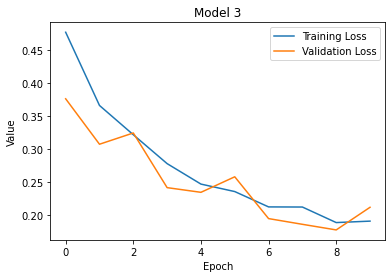

In [ ]:
#Best Model 3 loss train & validation
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Model 3')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

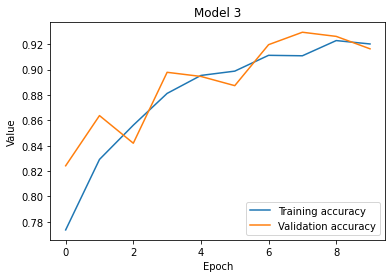

In [ ]:
#Best Model 3 acurracy train & validation
plt.plot(history_3.history['accuracy'], label='Training accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation accuracy')
plt.title('Model 3')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:
task_3.convergence_data()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([0.93859011, 0.94404072, 0.94404072, 0.94404072, 0.94404072,
        0.94440407, 0.94440407, 0.94440407]))

In [ ]:
iter, fitness_3 = task_3.convergence_data()

In [ ]:
fitness_3

array([0.93859011, 0.94404072, 0.94404072, 0.94404072, 0.94404072,
       0.94440407, 0.94440407, 0.94440407])

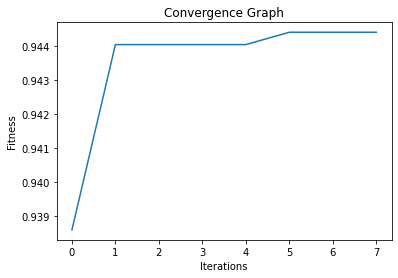

In [ ]:
task_3.plot_convergence()

In [ ]:
#Saving best model 3 and history
best_model_3.save("best_model_3.h5")
with open('history_params_fitness_3.pkl', 'wb') as f:
    pickle.dump([history_3.history, best_params_3, fitness_3], f)
print("Save Success")

Save Success


#### PSO Weight: 0.9, Constant 1: 0.5, Constant 2: 0.5

In [ ]:
print("Weight : {}".format(weight[0]) + ", Constant 1 : {}".format(constant1[1]) + ", Constant 2 : {}".format(constant2[1]))

Weight : 0.9, Constant 1 : 0.5, Constant 2 : 0.5


In [ ]:
best_params_4, history_4, best_model_4, task_4 = particleSwarmOptimization(train_data, val_data, weight[0], constant1[1], constant2[1])

=-----==-----==-----==-----==-----==-----==-----==-----==-----==-----=
Parameters
{'conv_layer': 2, 'fil1': 96, 'fil2': 64, 'fil3': 192, 'fil4': 128, 'ker_size': 5, 'conv_act': 'tanh', 'pool': 'max', 'pool_size': 3, 'dense_unit': 256, 'drop_rate': 0.2}
Epoch 1/10
258/258 - 76s - loss: 0.9394 - accuracy: 0.7252 - val_loss: 0.5792 - val_accuracy: 0.7384 - 76s/epoch - 295ms/step
Epoch 2/10
258/258 - 65s - loss: 0.5936 - accuracy: 0.7347 - val_loss: 0.5733 - val_accuracy: 0.7398 - 65s/epoch - 252ms/step
Epoch 3/10
258/258 - 65s - loss: 0.5933 - accuracy: 0.7342 - val_loss: 0.5757 - val_accuracy: 0.7387 - 65s/epoch - 252ms/step
Epoch 4/10
258/258 - 65s - loss: 0.5886 - accuracy: 0.7369 - val_loss: 0.5757 - val_accuracy: 0.7376 - 65s/epoch - 253ms/step
Epoch 5/10
258/258 - 65s - loss: 0.5902 - accuracy: 0.7370 - val_loss: 0.5765 - val_accuracy: 0.7373 - 65s/epoch - 253ms/step
Epoch 5: early stopping
=-----==-----==-----==-----==-----==-----==-----==-----==-----==-----=
Parameters
{'conv_laye

In [ ]:
best_model_4.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_284 (Conv2D)         (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_268 (MaxPooli  (None, 75, 75, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_285 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_269 (MaxPooli  (None, 37, 37, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_286 (Conv2D)         (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_270 (MaxPooli  (None, 18, 18, 96)     

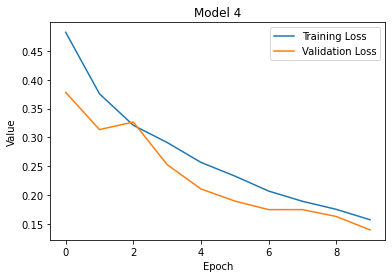

In [ ]:
#Best Model 4 loss train & validation
plt.plot(history_4.history['loss'], label='Training Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.title('Model 4')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

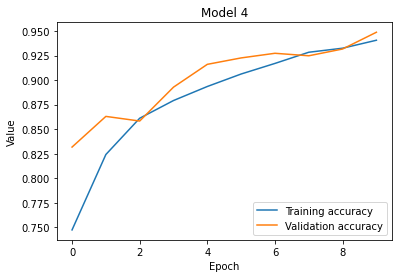

In [ ]:
#Best Model 4 acurracy train & validation
plt.plot(history_4.history['accuracy'], label='Training accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation accuracy')
plt.title('Model 4')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:
task_4.convergence_data()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([0.9375    , 0.94440407, 0.95603198, 0.95603198, 0.95748544,
        0.95748544, 0.95748544, 0.95748544]))

In [ ]:
iter, fitness_4 = task_4.convergence_data()

In [ ]:
fitness_4

array([0.9375    , 0.94440407, 0.95603198, 0.95603198, 0.95748544,
       0.95748544, 0.95748544, 0.95748544])

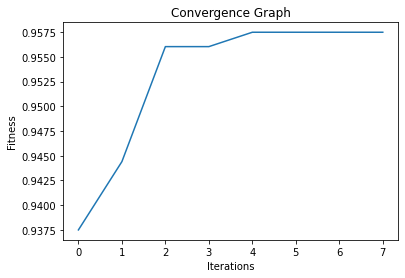

In [ ]:
task_4.plot_convergence()

In [ ]:
#Saving best model 4 and history
best_model_4.save("best_model_4.h5")
with open('history_params_fitness_4.pkl', 'wb') as f:
    pickle.dump([history_4.history, best_params_4, fitness_4], f)
print("Save Success")

Save Success


#### PSO Weight: 0.9, Constant 1: 0.3, Constant 2: 0.5

In [ ]:
print("Weight : {}".format(weight[0]) + ", Constant 1 : {}".format(constant1[0]) + ", Constant 2 : {}".format(constant2[1]))

Weight : 0.9, Constant 1 : 0.3, Constant 2 : 0.5


In [ ]:
best_params_5, history_5, best_model_5, task_5 = particleSwarmOptimization(train_data, val_data, weight[0], constant1[0], constant2[1])

=-----==-----==-----==-----==-----==-----==-----==-----==-----==-----=
Parameters
{'conv_layer': 2, 'fil1': 168, 'fil2': 96, 'fil3': 168, 'fil4': 192, 'ker_size': 5, 'conv_act': 'relu', 'pool': 'max', 'pool_size': 3, 'dense_unit': 256, 'drop_rate': 0.1}
Epoch 1/10
258/258 - 77s - loss: 0.5459 - accuracy: 0.7439 - val_loss: 0.4446 - val_accuracy: 0.7889 - 77s/epoch - 300ms/step
Epoch 2/10
258/258 - 65s - loss: 0.4460 - accuracy: 0.7839 - val_loss: 0.4157 - val_accuracy: 0.8001 - 65s/epoch - 254ms/step
Epoch 3/10
258/258 - 65s - loss: 0.4063 - accuracy: 0.8017 - val_loss: 0.3638 - val_accuracy: 0.8459 - 65s/epoch - 253ms/step
Epoch 4/10
258/258 - 65s - loss: 0.3628 - accuracy: 0.8305 - val_loss: 0.3365 - val_accuracy: 0.8554 - 65s/epoch - 253ms/step
Epoch 5/10
258/258 - 65s - loss: 0.3585 - accuracy: 0.8305 - val_loss: 0.3262 - val_accuracy: 0.8565 - 65s/epoch - 252ms/step
Epoch 6/10
258/258 - 65s - loss: 0.3253 - accuracy: 0.8520 - val_loss: 0.3051 - val_accuracy: 0.8656 - 65s/epoch - 2

In [ ]:
best_model_5.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_226 (Conv2D)         (None, 150, 150, 256)     7168      
                                                                 
 max_pooling2d_213 (MaxPooli  (None, 50, 50, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_227 (Conv2D)         (None, 50, 50, 96)        221280    
                                                                 
 max_pooling2d_214 (MaxPooli  (None, 16, 16, 96)       0         
 ng2D)                                                           
                                                                 
 conv2d_228 (Conv2D)         (None, 16, 16, 192)       166080    
                                                                 
 max_pooling2d_215 (MaxPooli  (None, 5, 5, 192)      

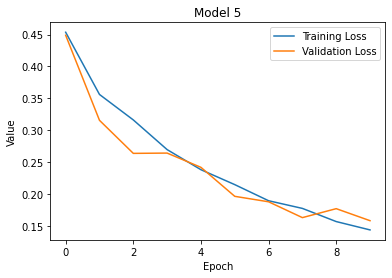

In [ ]:
#Best Model 5 loss train & validation
plt.plot(history_5.history['loss'], label='Training Loss')
plt.plot(history_5.history['val_loss'], label='Validation Loss')
plt.title('Model 5')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

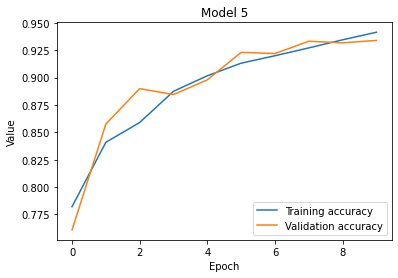

In [ ]:
#Best Model 5 acurracy train & validation
plt.plot(history_5.history['accuracy'], label='Training accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation accuracy')
plt.title('Model 5')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:
task_5.convergence_data()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([0.93350291, 0.93350291, 0.93422967, 0.94949126, 0.94949126,
        0.94949126, 0.94949126, 0.94949126]))

In [ ]:
iter, fitness_5 = task_5.convergence_data()

In [ ]:
fitness_5

array([0.93350291, 0.93350291, 0.93422967, 0.94949126, 0.94949126,
       0.94949126, 0.94949126, 0.94949126])

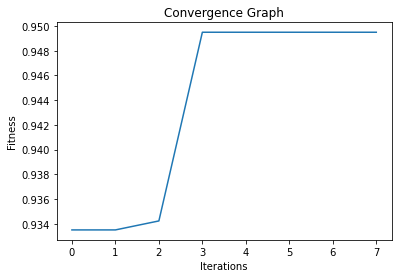

In [ ]:
task_5.plot_convergence()

In [ ]:
#Saving best model 5 and history
best_model_5.save("best_model_5.h5")
with open('history_params_fitness_5.pkl', 'wb') as f:
    pickle.dump([history_5.history, best_params_5, fitness_5], f)
print("Save Success")

Save Success


### Model Validation

In [ ]:
# buat validasi model

image_datagen = ImageDataGenerator(rescale=1./255)

train_generator = image_datagen.flow_from_directory(
                data+train,
                target_size=(150, 150),  
                batch_size=8284,
                shuffle=True,
                class_mode='binary'
                )
 
val_generator = image_datagen.flow_from_directory(
                data+val,
                target_size=(150, 150), 
                batch_size=2761, 
                shuffle=True,
                class_mode='binary'
                )


test_generator = image_datagen.flow_from_directory(
                 data+test, 
                 target_size=(150, 150), 
                 batch_size=2763,
                 shuffle=True,
                 class_mode='binary'
                 )

Found 8284 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.
Found 2763 images belonging to 2 classes.


In [ ]:
X_train, y_train = train_generator.next()
X_val, y_val = val_generator.next()
X_test, y_test = test_generator.next()

#### Dataset Distribution

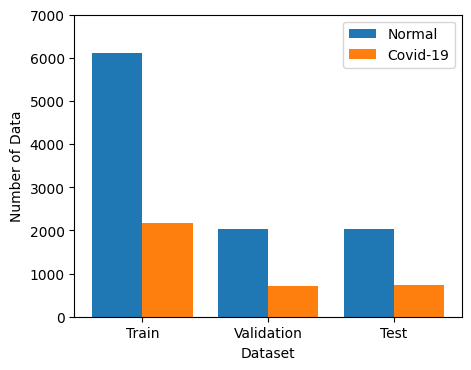

In [ ]:
X = ['Train','Validation','Test']
Normal = [6115, 2038, 2039]
Covid = [2169, 723, 724]

X_axis = np.arange(len(X))

figure(figsize=(5, 4), dpi=100) 
plt.bar(X_axis - 0.2, Normal, 0.4, label = 'Normal')
plt.bar(X_axis + 0.2, Covid, 0.4, label = 'Covid-19')
 
plt.xticks(X_axis, X)
plt.yticks(np.arange(0, 8000, 1000))
plt.xlabel("Dataset", fontsize=10)
plt.ylabel("Number of Data", fontsize=10)
plt.legend()
plt.show()

#### Load Model

In [ ]:
!unzip '/content/drive/MyDrive/TA/Baseline.zip' -d ''

Archive:  /content/drive/MyDrive/TA/Baseline.zip
   creating: Baseline/
  inflating: Baseline/baseline_model.h5  
  inflating: Baseline/history_params_baseline.pkl  


In [ ]:
!unzip '/content/drive/MyDrive/TA/Model.zip' -d ''

Archive:  /content/drive/MyDrive/TA/Model.zip
   creating: Model/
  inflating: Model/best_model_1.h5   
  inflating: Model/best_model_2.h5   
  inflating: Model/best_model_3.h5   
  inflating: Model/best_model_4.h5   
  inflating: Model/best_model_5.h5   
  inflating: Model/history_params_fitness_1.pkl  
  inflating: Model/history_params_fitness_2.pkl  
  inflating: Model/history_params_fitness_3.pkl  
  inflating: Model/history_params_fitness_4.pkl  
  inflating: Model/history_params_fitness_5.pkl  


In [ ]:
baseline_model = load_model('Baseline/baseline_model.h5')

In [ ]:
best_model_1 = load_model('Model/best_model_1.h5')
best_model_2 = load_model('Model/best_model_2.h5')
best_model_3 = load_model('Model/best_model_3.h5')
best_model_4 = load_model('Model/best_model_4.h5')
best_model_5 = load_model('Model/best_model_5.h5')

In [ ]:
# Baseline Model
with open('Baseline/history_params_baseline.pkl', 'rb') as f: 
    baseline_history, params = pickle.load(f)

In [ ]:
# Model 1
with open('Model/history_params_fitness_1.pkl', 'rb') as f: 
    history_1, best_params_1, fitness_1 = pickle.load(f)
# Model 2
with open('Model/history_params_fitness_2.pkl', 'rb') as f: 
    history_2, best_params_2, fitness_2 = pickle.load(f)
# Model 3
with open('Model/history_params_fitness_3.pkl', 'rb') as f: 
    history_3, best_params_3, fitness_3 = pickle.load(f)
# Model 4
with open('Model/history_params_fitness_4.pkl', 'rb') as f: 
    history_4, best_params_4, fitness_4 = pickle.load(f)
# Model 5
with open('Model/history_params_fitness_5.pkl', 'rb') as f: 
    history_5, best_params_5, fitness_5 = pickle.load(f)

#### Learning Curve Plot

##### Model 1

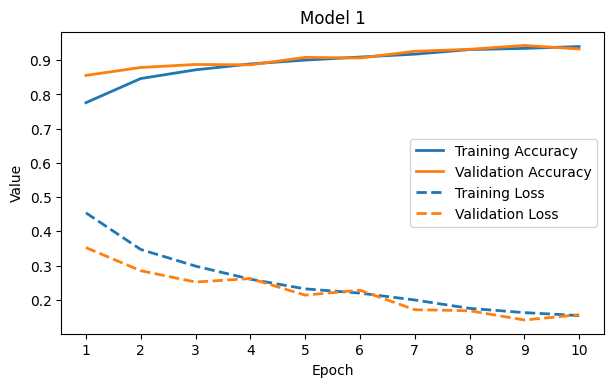

In [ ]:
figure(figsize=(7, 4), dpi=100)
plt.plot(history_1['accuracy'], label='Training Accuracy', linewidth=2, color="tab:blue")
plt.plot(history_1['val_accuracy'], label='Validation Accuracy', linewidth=2, color="tab:orange")
plt.plot(history_1['loss'],'--', label='Training Loss', linewidth=2, color="tab:blue")
plt.plot(history_1['val_loss'],'--', label='Validation Loss', linewidth=2, color="tab:orange")
plt.xticks(np.arange(len(history_1['accuracy'])), np.arange(1, len(history_1['accuracy'])+1))
plt.title('Model 1')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="center right", fontsize=10)
plt.savefig('Plot_model_1.png', dpi=1000)
plt.show()

##### Model 2

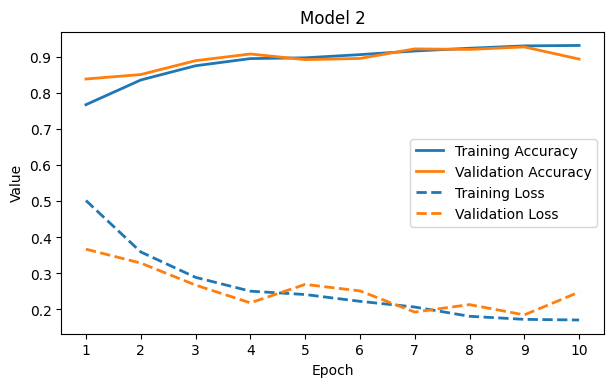

In [ ]:
figure(figsize=(7, 4), dpi=100)
plt.plot(history_2['accuracy'], label='Training Accuracy', linewidth=2, color="tab:blue")
plt.plot(history_2['val_accuracy'], label='Validation Accuracy', linewidth=2, color="tab:orange")
plt.plot(history_2['loss'],'--', label='Training Loss', linewidth=2, color="tab:blue")
plt.plot(history_2['val_loss'],'--', label='Validation Loss', linewidth=2, color="tab:orange")
plt.xticks(np.arange(len(history_2['accuracy'])), np.arange(1, len(history_2['accuracy'])+1))
plt.title('Model 2')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="center right", fontsize=10)
plt.savefig('Plot_model_2.png', dpi=1000)
plt.show()

##### Model 3

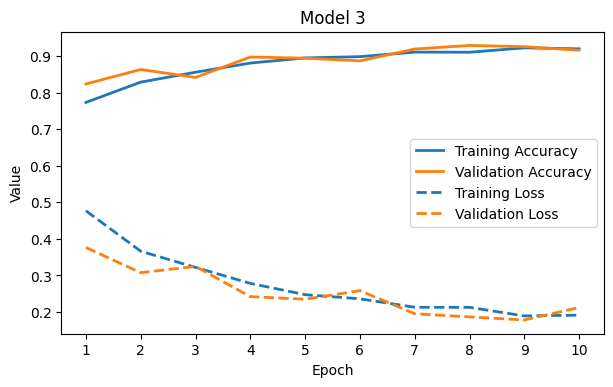

In [ ]:
figure(figsize=(7, 4), dpi=100)
plt.plot(history_3['accuracy'], label='Training Accuracy', linewidth=2, color="tab:blue")
plt.plot(history_3['val_accuracy'], label='Validation Accuracy', linewidth=2, color="tab:orange")
plt.plot(history_3['loss'],'--', label='Training Loss', linewidth=2, color="tab:blue")
plt.plot(history_3['val_loss'],'--', label='Validation Loss', linewidth=2, color="tab:orange")
plt.xticks(np.arange(len(history_3['accuracy'])), np.arange(1, len(history_3['accuracy'])+1))
plt.title('Model 3')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="center right", fontsize=10)
plt.savefig('Plot_model_3.png', dpi=1000)
plt.show()

##### Model 4

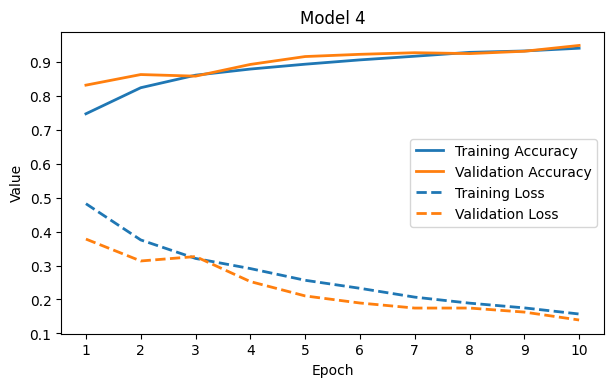

In [ ]:
figure(figsize=(7, 4), dpi=100)
plt.plot(history_4['accuracy'], label='Training Accuracy', linewidth=2, color="tab:blue")
plt.plot(history_4['val_accuracy'], label='Validation Accuracy', linewidth=2, color="tab:orange")
plt.plot(history_4['loss'],'--', label='Training Loss', linewidth=2, color="tab:blue")
plt.plot(history_4['val_loss'],'--', label='Validation Loss', linewidth=2, color="tab:orange")
plt.xticks(np.arange(len(history_4['accuracy'])), np.arange(1, len(history_4['accuracy'])+1))
plt.title('Model 4')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="center right", fontsize=10)
plt.savefig('Plot_model_4.png', dpi=1000)
plt.show()

##### Model 5

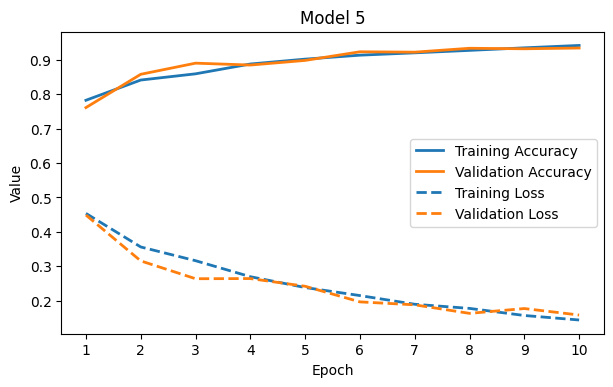

In [ ]:
figure(figsize=(7, 4), dpi=100)
plt.plot(history_5['accuracy'], label='Training Accuracy', linewidth=2, color="tab:blue")
plt.plot(history_5['val_accuracy'], label='Validation Accuracy', linewidth=2, color="tab:orange")
plt.plot(history_5['loss'],'--', label='Training Loss', linewidth=2, color="tab:blue")
plt.plot(history_5['val_loss'],'--', label='Validation Loss', linewidth=2, color="tab:orange")
plt.xticks(np.arange(len(history_5['accuracy'])), np.arange(1, len(history_5['accuracy'])+1))
plt.title('Model 5')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="center right", fontsize=10)
plt.savefig('Plot_model_5.png', dpi=1000)
plt.show()

#### Convergence Plot

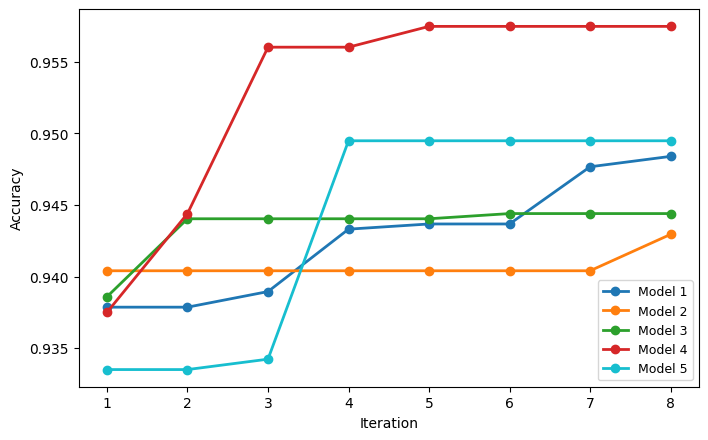

In [ ]:
figure(figsize=(8, 5), dpi=100)
plt.plot(fitness_1, label='Model 1', linewidth=2, color="tab:blue", marker='o')
plt.plot(fitness_2, label='Model 2', linewidth=2, color="tab:orange", marker='o')
plt.plot(fitness_3, label='Model 3', linewidth=2, color="tab:green", marker='o')
plt.plot(fitness_4, label='Model 4', linewidth=2, color="tab:red", marker='o')
plt.plot(fitness_5, label='Model 5', linewidth=2, color="tab:cyan", marker='o')
plt.xticks(np.arange(len(fitness_1)), np.arange(1, len(fitness_1)+1))
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.legend(loc="lower right", fontsize=9)
plt.savefig('Plot_convegennce.png', dpi=1000)
plt.show()

#### Bar Plot

##### Weight

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = 'center')

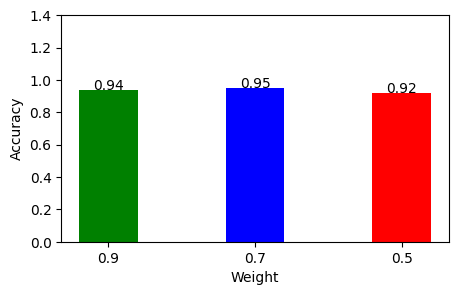

In [ ]:
# Model Accuracy (Test)
model1 = 0.94
model2 = 0.95
model3 = 0.92

model = ['0.9', '0.7', '0.5']
acc = [model1, model2, model3]

figure(figsize=(5, 3), dpi=100)
colors = ['green','blue','red']
plt.bar(model, acc, color=colors, width=0.4)
addlabels(model, acc)
plt.xlabel('Weight', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.yticks(np.arange(0, 1.5, 0.2))
# plt.grid(True)
plt.savefig('bar_plot_weight.png', dpi=1000)
plt.show()

##### Constant

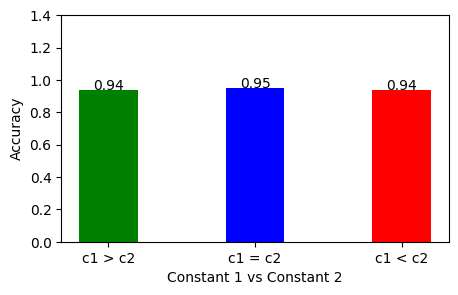

In [ ]:
# Model Accuracy (Test)
model1 = 0.94
model4 = 0.95
model5 = 0.94

model = ['c1 > c2', 'c1 = c2', 'c1 < c2']
acc = [model1, model4, model5]

figure(figsize=(5, 3), dpi=100)
colors = ['green','blue','red']
plt.bar(model, acc, color=colors, width=0.4)
addlabels(model, acc)
plt.xlabel('Constant 1 vs Constant 2', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.yticks(np.arange(0, 1.5, 0.2))
# plt.grid(True)
plt.savefig('bar_plot_constant.png', dpi=1000)
plt.show()

#### Baseline model evaluation

##### Data Train

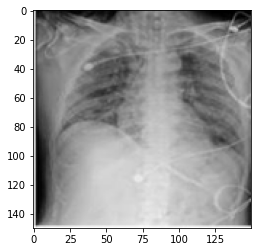

In [ ]:
for idx in range(1):
  plt.imshow(X_train[idx])

In [ ]:
print(baseline_model.predict(X_train))

[[0.04919803]
 [0.9725419 ]
 [0.98846066]
 ...
 [0.9976277 ]
 [0.9461147 ]
 [0.99908245]]


In [ ]:
print("Number of Data Train {}".format(len(X_train)))
predict = (baseline_model.predict(X_train) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Train 8284
Predict : [0 1 1 ... 1 1 1]


In [ ]:
print(y_train)

[0. 1. 1. ... 1. 1. 1.]


In [ ]:
print(classification_report(y_train, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.94      0.54      0.68      2169
      Normal       0.86      0.99      0.92      6115

    accuracy                           0.87      8284
   macro avg       0.90      0.76      0.80      8284
weighted avg       0.88      0.87      0.86      8284



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_train, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_train, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_train, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_train, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_train, predict)))

Precision Score : 0.86
Accuracy Score : 0.87
F1 Score : 0.92
Recall Score : 0.99
ROAUC Score : 0.76


Text(51.0, 0.5, 'Actual')

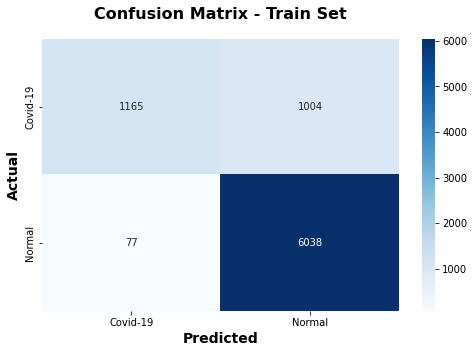

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_train, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Train Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 

##### Data Validation

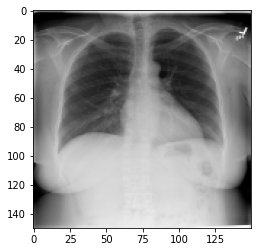

In [ ]:
for idx in range(1):
  plt.imshow(X_val[idx])

In [ ]:
print(baseline_model.predict(X_val))

[[0.9659619 ]
 [0.99384993]
 [0.98415655]
 ...
 [0.35966265]
 [0.9764397 ]
 [0.7306305 ]]


In [ ]:
print("Number of Data Validation {}".format(len(X_val)))
predict = (baseline_model.predict(X_val) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Validation 2761
Predict : [1 1 1 ... 0 1 1]


In [ ]:
print(y_val)

[1. 1. 1. ... 0. 1. 1.]


In [ ]:
print(classification_report(y_val, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.93      0.49      0.64       723
      Normal       0.84      0.99      0.91      2038

    accuracy                           0.86      2761
   macro avg       0.89      0.74      0.77      2761
weighted avg       0.87      0.86      0.84      2761



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_val, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_val, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_val, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_val, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_val, predict)))

Precision Score : 0.84
Accuracy Score : 0.86
F1 Score : 0.91
Recall Score : 0.99
ROAUC Score : 0.74


Text(51.0, 0.5, 'Actual')

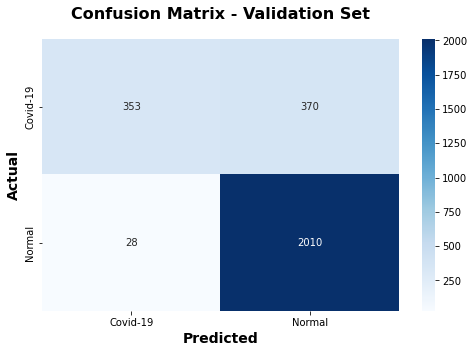

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_val, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Validation Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 

##### Data Test

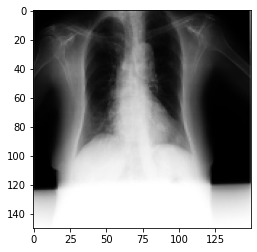

In [ ]:
for idx in range(1):
  plt.imshow(X_test[idx])

In [ ]:
print(baseline_model.predict(X_test))

[[0.9759887 ]
 [0.7214778 ]
 [0.99635315]
 ...
 [0.93852925]
 [0.980584  ]
 [0.90916705]]


In [ ]:
print("Number of Data Test {}".format(len(X_test)))
predict = (baseline_model.predict(X_test) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Test 2763
Predict : [1 1 1 ... 1 1 1]


In [ ]:
print(y_test)

[0. 1. 1. ... 1. 1. 1.]


In [ ]:
print(classification_report(y_test, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.92      0.53      0.67       724
      Normal       0.86      0.98      0.91      2039

    accuracy                           0.87      2763
   macro avg       0.89      0.76      0.79      2763
weighted avg       0.87      0.87      0.85      2763



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_test, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_test, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_test, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_test, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_test, predict)))

Precision Score : 0.86
Accuracy Score : 0.87
F1 Score : 0.91
Recall Score : 0.98
ROAUC Score : 0.76


Text(51.0, 0.5, 'Actual')

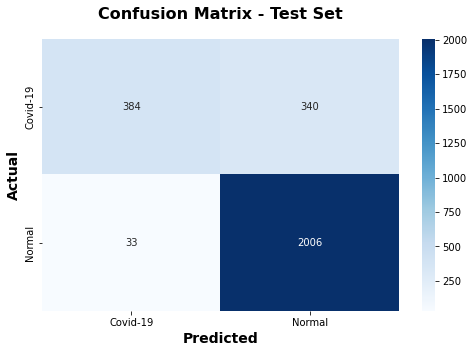

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_test, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 

#### PSO Weight: 0.9, Constant 1: 0.5, Constant 2: 0.3

##### Data Train

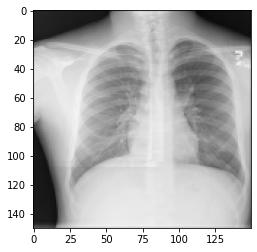

In [ ]:
for idx in range(1):
  plt.imshow(X_train[idx])

In [ ]:
print(best_model_1.predict(X_train))

[[0.9984357 ]
 [0.9999999 ]
 [0.998481  ]
 ...
 [0.99748695]
 [0.98044443]
 [0.9980653 ]]


In [ ]:
print("Number of Data Train {}".format(len(X_train)))
predict = (best_model_1.predict(X_train) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Train 8284
Predict : [1 1 1 ... 1 1 1]


In [ ]:
print(y_train)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
print(classification_report(y_train, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.98      0.88      0.93      2169
      Normal       0.96      0.99      0.98      6115

    accuracy                           0.96      8284
   macro avg       0.97      0.94      0.95      8284
weighted avg       0.96      0.96      0.96      8284



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_train, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_train, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_train, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_train, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_train, predict)))

Precision Score : 0.96
Accuracy Score : 0.96
F1 Score : 0.98
Recall Score : 0.99
ROAUC Score : 0.94


Text(51.0, 0.5, 'Actual')

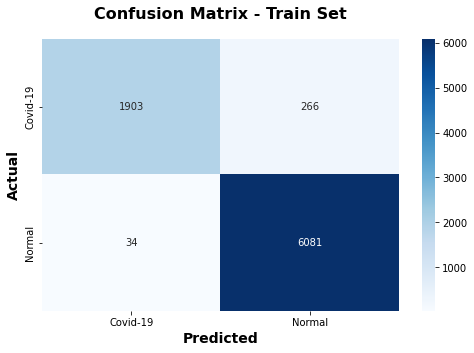

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_train, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Train Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 

##### Data Validation

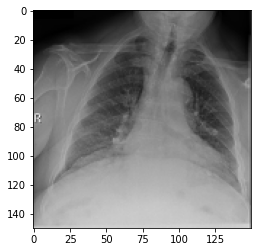

In [ ]:
for idx in range(1):
  plt.imshow(X_val[idx])

In [ ]:
print(best_model_1.predict(X_val))

[[0.22691324]
 [1.        ]
 [0.99999976]
 ...
 [0.05399432]
 [0.9160552 ]
 [0.01347218]]


In [ ]:
print("Number of Data Validation {}".format(len(X_val)))
predict = (best_model_1.predict(X_val) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Validation 2761
Predict : [0 1 1 ... 0 1 0]


In [ ]:
print(y_val)

[0. 1. 1. ... 0. 1. 0.]


In [ ]:
print(classification_report(y_val, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.97      0.83      0.89       723
      Normal       0.94      0.99      0.97      2038

    accuracy                           0.95      2761
   macro avg       0.96      0.91      0.93      2761
weighted avg       0.95      0.95      0.95      2761



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_val, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_val, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_val, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_val, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_val, predict)))

Precision Score : 0.94
Accuracy Score : 0.95
F1 Score : 0.97
Recall Score : 0.99
ROAUC Score : 0.91


Text(51.0, 0.5, 'Actual')

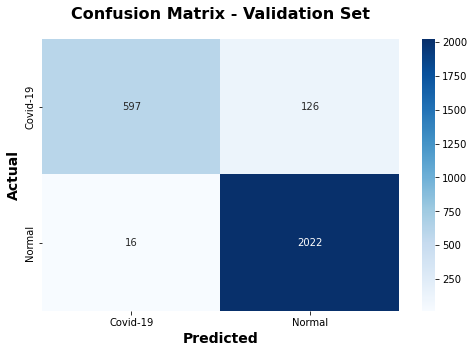

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_val, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Validation Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 

##### Data Test

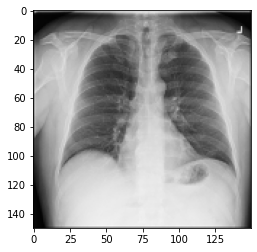

In [ ]:
for idx in range(1):
  plt.imshow(X_test[idx])

In [ ]:
print(best_model_1.predict(X_test))

[[1.        ]
 [0.9999856 ]
 [0.99992895]
 ...
 [0.99999964]
 [0.6949149 ]
 [0.96402323]]


In [ ]:
print("Number of Data Test {}".format(len(X_test)))
predict = (best_model_1.predict(X_test) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Test 2763
Predict : [1 1 1 ... 1 1 1]


In [ ]:
print(y_test)

[1. 1. 1. ... 1. 0. 1.]


In [ ]:
print(classification_report(y_test, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.96      0.82      0.89       724
      Normal       0.94      0.99      0.96      2039

    accuracy                           0.94      2763
   macro avg       0.95      0.91      0.93      2763
weighted avg       0.95      0.94      0.94      2763



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_test, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_test, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_test, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_test, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_test, predict)))

Precision Score : 0.94
Accuracy Score : 0.94
F1 Score : 0.96
Recall Score : 0.99
ROAUC Score : 0.91


Text(51.0, 0.5, 'Actual')

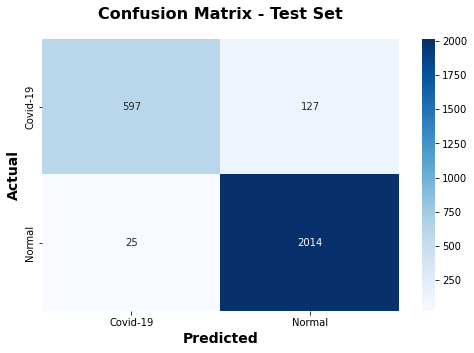

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_test, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 

#### PSO Weight: 0.7, Constant 1: 0.5, Constant 2: 0.3

##### Data Train

In [ ]:
print(best_model_2.predict(X_train))

[[0.97231525]
 [0.99063474]
 [0.98956025]
 ...
 [0.87948316]
 [0.998042  ]
 [0.991593  ]]


In [ ]:
print("Number of Data Train {}".format(len(X_train)))
predict = (best_model_2.predict(X_train) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Train 8284
Predict : [1 1 1 ... 1 1 1]


In [ ]:
print(y_train)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
print(classification_report(y_train, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.94      0.92      0.93      2169
      Normal       0.97      0.98      0.97      6115

    accuracy                           0.96      8284
   macro avg       0.95      0.95      0.95      8284
weighted avg       0.96      0.96      0.96      8284



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_train, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_train, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_train, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_train, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_train, predict)))

Precision Score : 0.97
Accuracy Score : 0.96
F1 Score : 0.97
Recall Score : 0.98
ROAUC Score : 0.95


Text(51.0, 0.5, 'Actual')

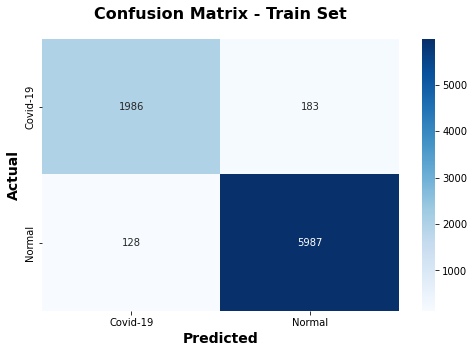

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_train, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Train Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 

##### Data Validation

In [ ]:
print(best_model_2.predict(X_val))

[[0.03866396]
 [0.9922908 ]
 [0.9994143 ]
 ...
 [0.7946486 ]
 [0.9240953 ]
 [0.09579138]]


In [ ]:
print("Number of Data Validation {}".format(len(X_val)))
predict = (best_model_2.predict(X_val) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Validation 2761
Predict : [0 1 1 ... 1 1 0]


In [ ]:
print(y_val)

[0. 1. 1. ... 0. 1. 0.]


In [ ]:
print(classification_report(y_val, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.93      0.86      0.90       723
      Normal       0.95      0.98      0.97      2038

    accuracy                           0.95      2761
   macro avg       0.94      0.92      0.93      2761
weighted avg       0.95      0.95      0.95      2761



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_val, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_val, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_val, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_val, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_val, predict)))

Precision Score : 0.95
Accuracy Score : 0.95
F1 Score : 0.97
Recall Score : 0.98
ROAUC Score : 0.92


Text(51.0, 0.5, 'Actual')

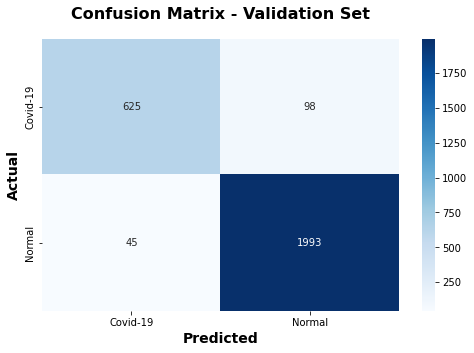

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_val, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Validation Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 

##### Data Test

In [ ]:
print(best_model_2.predict(X_test))

[[0.99503136]
 [0.9941917 ]
 [0.9846554 ]
 ...
 [0.9960867 ]
 [0.17220987]
 [0.9651168 ]]


In [ ]:
print("Number of Data Test {}".format(len(X_test)))
predict = (best_model_2.predict(X_test) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Test 2763
Predict : [1 1 1 ... 1 0 1]


In [ ]:
print(y_test)

[1. 1. 1. ... 1. 0. 1.]


In [ ]:
print(classification_report(y_test, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.90      0.90      0.90       724
      Normal       0.96      0.97      0.96      2039

    accuracy                           0.95      2763
   macro avg       0.93      0.93      0.93      2763
weighted avg       0.95      0.95      0.95      2763



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_test, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_test, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_test, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_test, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_test, predict)))

Precision Score : 0.96
Accuracy Score : 0.95
F1 Score : 0.96
Recall Score : 0.97
ROAUC Score : 0.93


Text(51.0, 0.5, 'Actual')

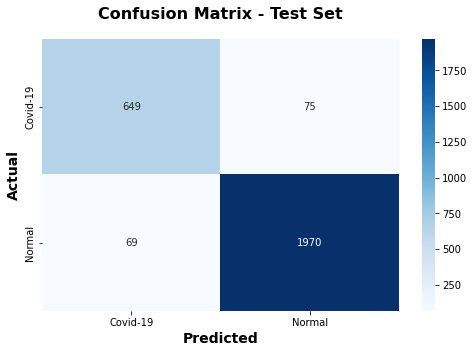

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_test, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 

#### PSO Weight: 0.5, Constant 1: 0.5, Constant 2: 0.3

##### Data Train

In [ ]:
print(best_model_3.predict(X_train))

[[0.9981997 ]
 [1.        ]
 [0.99398935]
 ...
 [0.99895084]
 [0.99564654]
 [0.9895586 ]]


In [ ]:
print("Number of Data Train {}".format(len(X_train)))
predict = (best_model_3.predict(X_train) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Train 8284
Predict : [1 1 1 ... 1 1 1]


In [ ]:
print(y_train)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
print(classification_report(y_train, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.98      0.72      0.83      2169
      Normal       0.91      1.00      0.95      6115

    accuracy                           0.92      8284
   macro avg       0.95      0.86      0.89      8284
weighted avg       0.93      0.92      0.92      8284



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_train, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_train, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_train, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_train, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_train, predict)))

Precision Score : 0.91
Accuracyi Score : 0.92
F1 Score : 0.95
Recall Score : 1.00
ROAUC Score : 0.86


Text(51.0, 0.5, 'Actual')

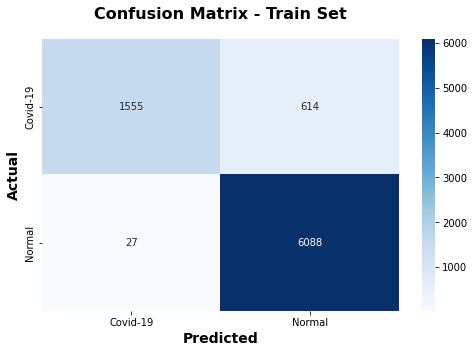

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_train, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Train Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')

##### Data Validation

In [ ]:
print(best_model_3.predict(X_val))

[[0.08945608]
 [0.9999579 ]
 [1.        ]
 ...
 [0.67805254]
 [0.9831872 ]
 [0.39891335]]


In [ ]:
print("Number of Data Validation {}".format(len(X_val)))
predict = (best_model_3.predict(X_val) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Validation 2761
Predict : [0 1 1 ... 1 1 0]


In [ ]:
print(y_val)

[0. 1. 1. ... 0. 1. 0.]


In [ ]:
print(classification_report(y_val, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.98      0.69      0.81       723
      Normal       0.90      1.00      0.95      2038

    accuracy                           0.91      2761
   macro avg       0.94      0.84      0.88      2761
weighted avg       0.92      0.91      0.91      2761



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_val, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_val, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_val, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_val, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_val, predict)))

Precision Score : 0.90
Accuracy Score : 0.91
F1 Score : 0.95
Recall Score : 1.00
ROAUC Score : 0.84


Text(51.0, 0.5, 'Actual')

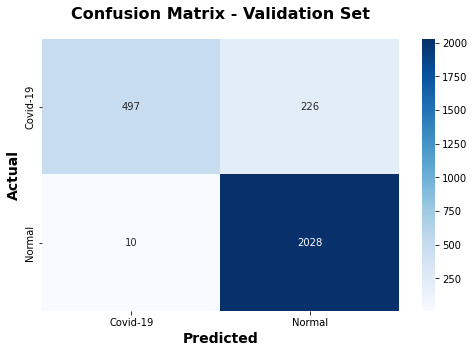

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_val, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Validation Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')

##### Data Test

In [ ]:
print(best_model_3.predict(X_test))

[[1.        ]
 [0.99999964]
 [1.        ]
 ...
 [0.9999995 ]
 [0.82921785]
 [0.9897114 ]]


In [ ]:
print("Number of Data Test {}".format(len(X_test)))
predict = (best_model_3.predict(X_test) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Test 2763
Predict : [1 1 1 ... 1 1 1]


In [ ]:
print(y_test)

[1. 1. 1. ... 1. 0. 1.]


In [ ]:
print(classification_report(y_test, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.96      0.72      0.82       724
      Normal       0.91      0.99      0.95      2039

    accuracy                           0.92      2763
   macro avg       0.93      0.85      0.88      2763
weighted avg       0.92      0.92      0.91      2763



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_test, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_test, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_test, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_test, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_test, predict)))

Precision Score : 0.91
Accuracy Score : 0.92
F1 Score : 0.95
Recall Score : 0.99
ROAUC Score : 0.85


Text(51.0, 0.5, 'Actual')

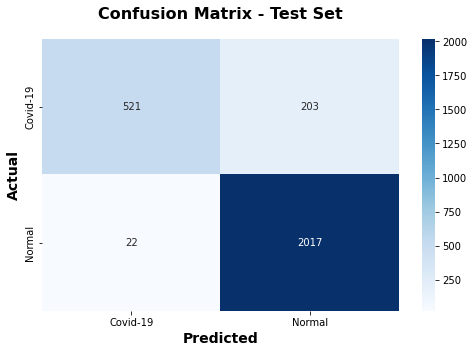

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_test, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')

#### PSO Weight: 0.9, Constant 1: 0.5, Constant 2: 0.5

##### Data Train

In [ ]:
print(best_model_4.predict(X_train))

[[0.99916005]
 [0.99979633]
 [0.9855774 ]
 ...
 [0.9775737 ]
 [0.9999131 ]
 [0.97760165]]


In [ ]:
print("Number of Data Train {}".format(len(X_train)))
predict = (best_model_4.predict(X_train) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Train 8284
Predict : [1 1 1 ... 1 1 1]


In [ ]:
print(y_train)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
print(classification_report(y_train, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.98      0.86      0.92      2169
      Normal       0.95      0.99      0.97      6115

    accuracy                           0.96      8284
   macro avg       0.97      0.93      0.94      8284
weighted avg       0.96      0.96      0.96      8284



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_train, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_train, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_train, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_train, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_train, predict)))

Precision Score : 0.95
Accuracy Score : 0.96
F1 Score : 0.97
Recall Score : 0.99
ROAUC Score : 0.93


Text(51.0, 0.5, 'Actual')

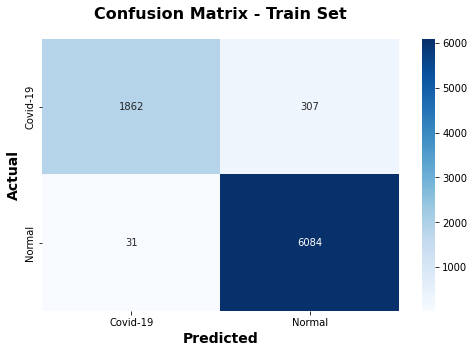

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_train, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Train Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')

##### Data Validation

In [ ]:
print(best_model_4.predict(X_val))

[[0.10433571]
 [0.9999604 ]
 [1.        ]
 ...
 [0.10207114]
 [0.9997075 ]
 [0.08593646]]


In [ ]:
print("Number of Data Validation {}".format(len(X_val)))
predict = (best_model_4.predict(X_val) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Validation 2761
Predict : [0 1 1 ... 0 1 0]


In [ ]:
print(y_val)

[0. 1. 1. ... 0. 1. 0.]


In [ ]:
print(classification_report(y_val, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.99      0.84      0.91       723
      Normal       0.95      1.00      0.97      2038

    accuracy                           0.96      2761
   macro avg       0.97      0.92      0.94      2761
weighted avg       0.96      0.96      0.95      2761



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_val, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_val, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_val, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_val, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_val, predict)))

Precision Score : 0.95
Accuracy Score : 0.96
F1 Score : 0.97
Recall Score : 1.00
ROAUC Score : 0.92


Text(51.0, 0.5, 'Actual')

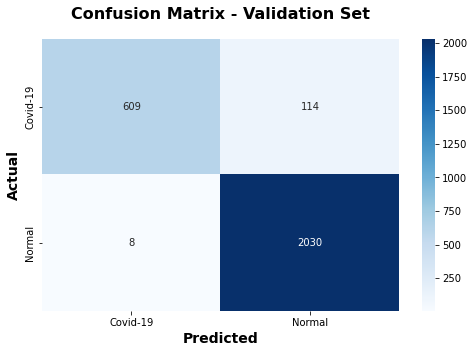

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_val, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Validation Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')

##### Data Test

In [ ]:
print(best_model_4.predict(X_test))

[[1.        ]
 [0.9999107 ]
 [0.99981505]
 ...
 [0.9999987 ]
 [0.18989396]
 [0.99863666]]


In [ ]:
print("Number of Data Test {}".format(len(X_test)))
predict = (best_model_4.predict(X_test) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Test 2763
Predict : [1 1 1 ... 1 0 1]


In [ ]:
print(y_test)

[1. 1. 1. ... 1. 0. 1.]


In [ ]:
print(classification_report(y_test, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.96      0.84      0.90       724
      Normal       0.94      0.99      0.97      2039

    accuracy                           0.95      2763
   macro avg       0.95      0.91      0.93      2763
weighted avg       0.95      0.95      0.95      2763



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_test, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_test, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_test, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_test, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_test, predict)))

Precision Score : 0.94
Accuracy Score : 0.95
F1 Score : 0.97
Recall Score : 0.99
ROAUC Score : 0.91


Text(51.0, 0.5, 'Actual')

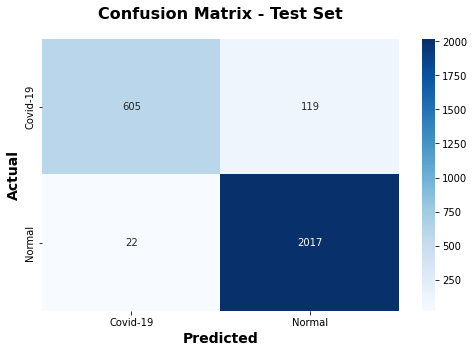

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_test, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')

#### PSO Weight: 0.9, Constant 1: 0.3, Constant 2: 0.5

##### Data Train

In [ ]:
print(best_model_5.predict(X_train))

[[0.9995931 ]
 [1.        ]
 [0.9999815 ]
 ...
 [0.9999273 ]
 [0.99862075]
 [0.9991602 ]]


In [ ]:
print("Number of Data Train {}".format(len(X_train)))
predict = (best_model_5.predict(X_train) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Train 8284
Predict : [1 1 1 ... 1 1 1]


In [ ]:
print(y_train)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
print(classification_report(y_train, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.98      0.85      0.91      2169
      Normal       0.95      1.00      0.97      6115

    accuracy                           0.96      8284
   macro avg       0.97      0.92      0.94      8284
weighted avg       0.96      0.96      0.96      8284



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_train, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_train, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_train, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_train, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_train, predict)))

Precision Score : 0.95
Accuracy Score : 0.96
F1 Score : 0.97
Recall Score : 1.00
ROAUC Score : 0.92


Text(51.0, 0.5, 'Actual')

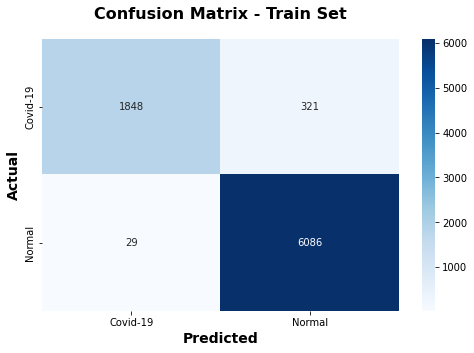

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_train, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Train Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')

##### Data Validation

In [ ]:
print(best_model_5.predict(X_val))

[[0.16915566]
 [1.        ]
 [1.        ]
 ...
 [0.05943941]
 [0.19967353]
 [0.15466303]]


In [ ]:
print("Number of Data Validation {}".format(len(X_val)))
predict = (best_model_5.predict(X_val) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Validation 2761
Predict : [0 1 1 ... 0 0 0]


In [ ]:
print(y_val)

[0. 1. 1. ... 0. 1. 0.]


In [ ]:
print(classification_report(y_val, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.98      0.81      0.89       723
      Normal       0.94      1.00      0.96      2038

    accuracy                           0.95      2761
   macro avg       0.96      0.90      0.93      2761
weighted avg       0.95      0.95      0.94      2761



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_val, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_val, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_val, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_val, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_val, predict)))

Precision Score : 0.94
Accuracy Score : 0.95
F1 Score : 0.96
Recall Score : 1.00
ROAUC Score : 0.90


Text(51.0, 0.5, 'Actual')

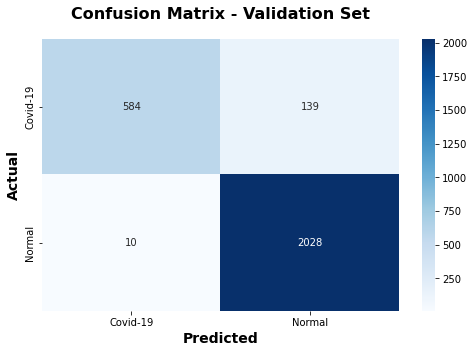

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_val, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Validation Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')

##### Data Test

In [ ]:
print(best_model_5.predict(X_test))

[[1.        ]
 [0.99999475]
 [0.9999882 ]
 ...
 [1.        ]
 [0.5828226 ]
 [0.9985435 ]]


In [ ]:
print("Number of Data Test {}".format(len(X_test)))
predict = (best_model_5.predict(X_test) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print("Predict : {}".format(predict))

Number of Data Test 2763
Predict : [1 1 1 ... 1 1 1]


In [ ]:
print(y_test)

[1. 1. 1. ... 1. 0. 1.]


In [ ]:
print(classification_report(y_test, predict, target_names = ['COVID','Normal']))

              precision    recall  f1-score   support

       COVID       0.98      0.80      0.88       724
      Normal       0.93      0.99      0.96      2039

    accuracy                           0.94      2763
   macro avg       0.96      0.90      0.92      2763
weighted avg       0.94      0.94      0.94      2763



In [ ]:
print("Precision Score : {:.2f}".format(precision_score(y_test, predict, average='binary')))
print("Accuracy Score : {:.2f}".format(accuracy_score(y_test, predict)))
print("F1 Score : {:.2f}".format(f1_score(y_test, predict, average='binary')))
print("Recall Score : {:.2f}".format(recall_score(y_test, predict, average='binary')))
print("ROAUC Score : {:.2f}".format(roc_auc_score(y_test, predict)))

Precision Score : 0.93
Accuracy Score : 0.94
F1 Score : 0.96
Recall Score : 0.99
ROAUC Score : 0.90


Text(51.0, 0.5, 'Actual')

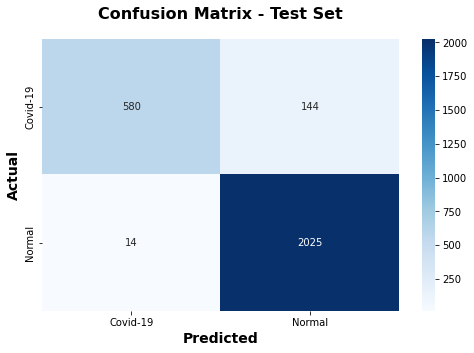

In [ ]:
plt.figure(figsize=(8, 5))
classes = ['Covid-19','Normal']
CMatrix = pd.DataFrame(confusion_matrix(y_test, predict), columns=classes, index =classes)
ax = sns.heatmap(CMatrix, cmap="Blues", annot=True,fmt=".0f")
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')

#### Sample Picture for Best Model (Model 4)

In [ ]:
predict = (best_model_4.predict(X_test) > 0.5).astype("int")
predict = predict.reshape(1, -1)[0]
print(predict)

[1 1 1 ... 0 0 0]


In [ ]:
print(y_test)

[1. 1. 1. ... 0. 0. 0.]


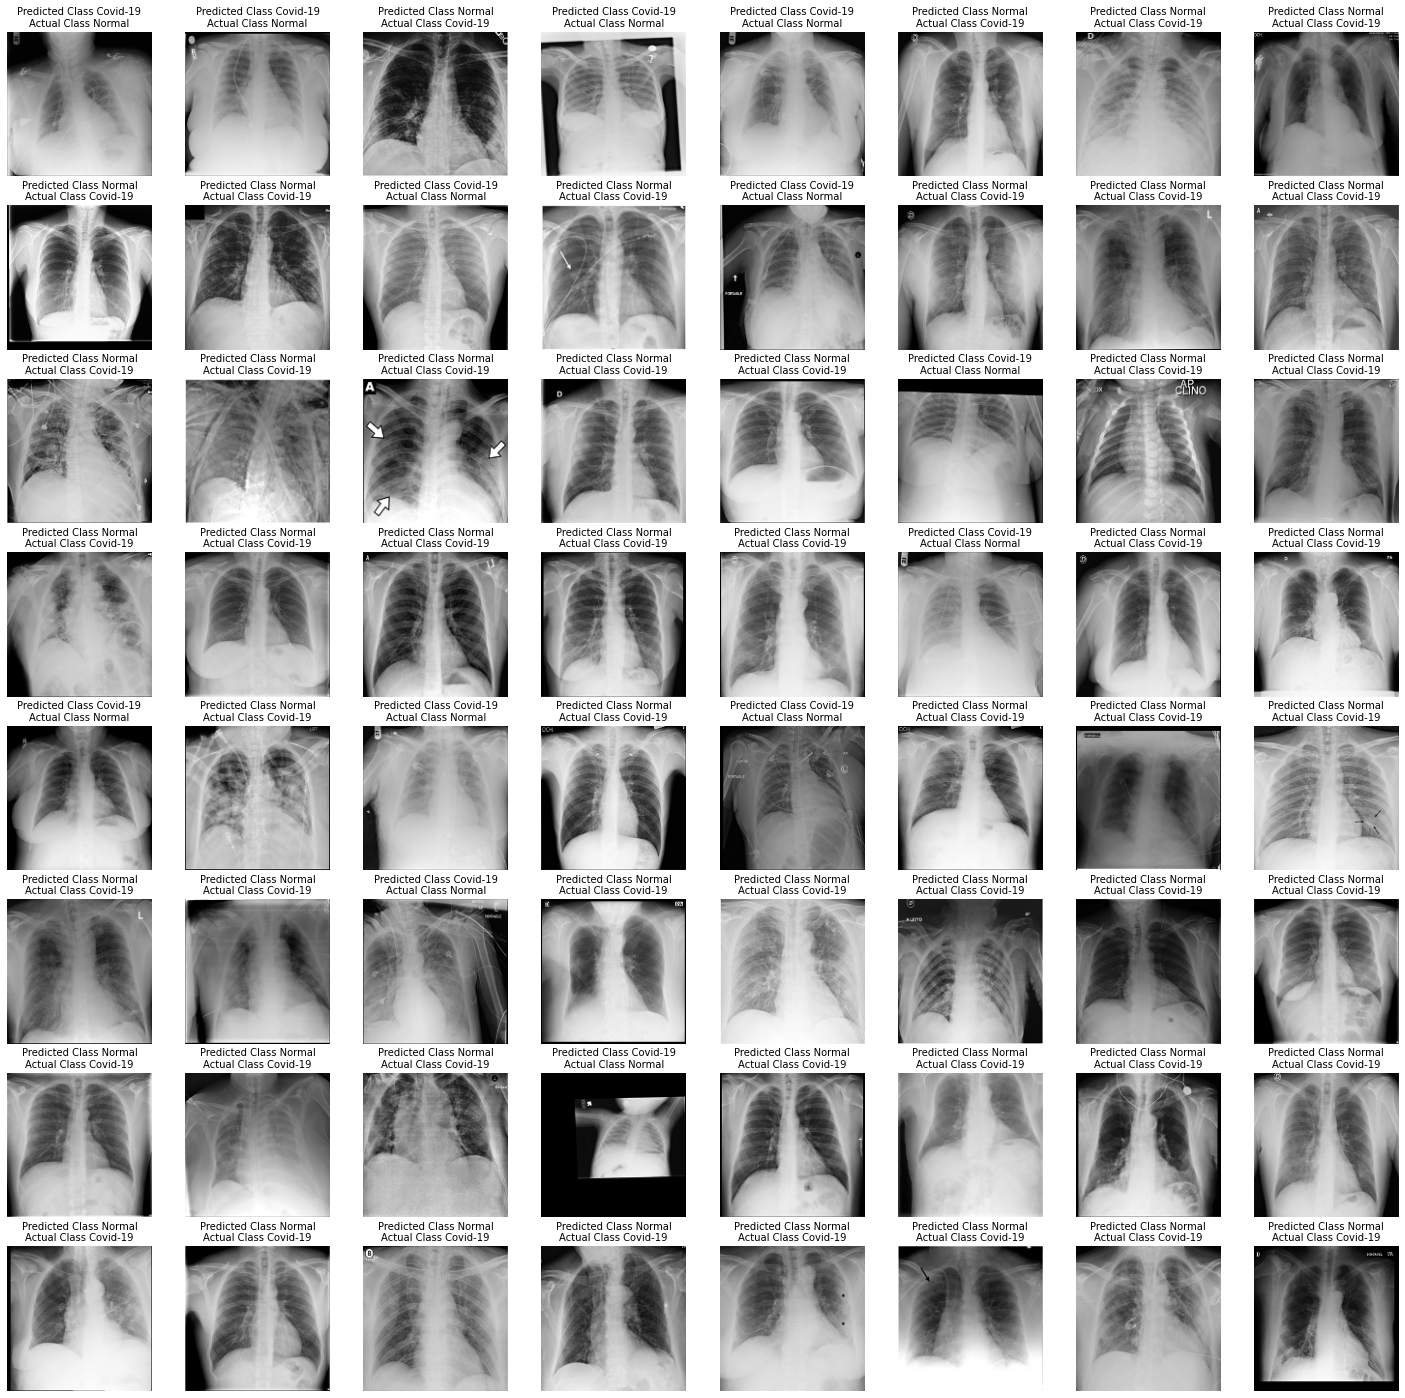

In [ ]:
incorrect = np.nonzero(predict != y_test)[0]
labels_actual = ['Normal' if label == 1 else 'Covid-19' for label in y_test]
labels_predict = ['Normal' if label == 1 else 'Covid-19' for label in predict]

i = 0
plt.figure(figsize=(25, 25))
for c in incorrect[:64]:
    plt.subplot(8,8,i+1)
    plt.imshow(X_test[c], cmap="cool")
    plt.title("Predicted Class {}\nActual Class {}".format(labels_predict[c], labels_actual[c]), fontsize=10,)
    plt.axis('off')
    i +=1

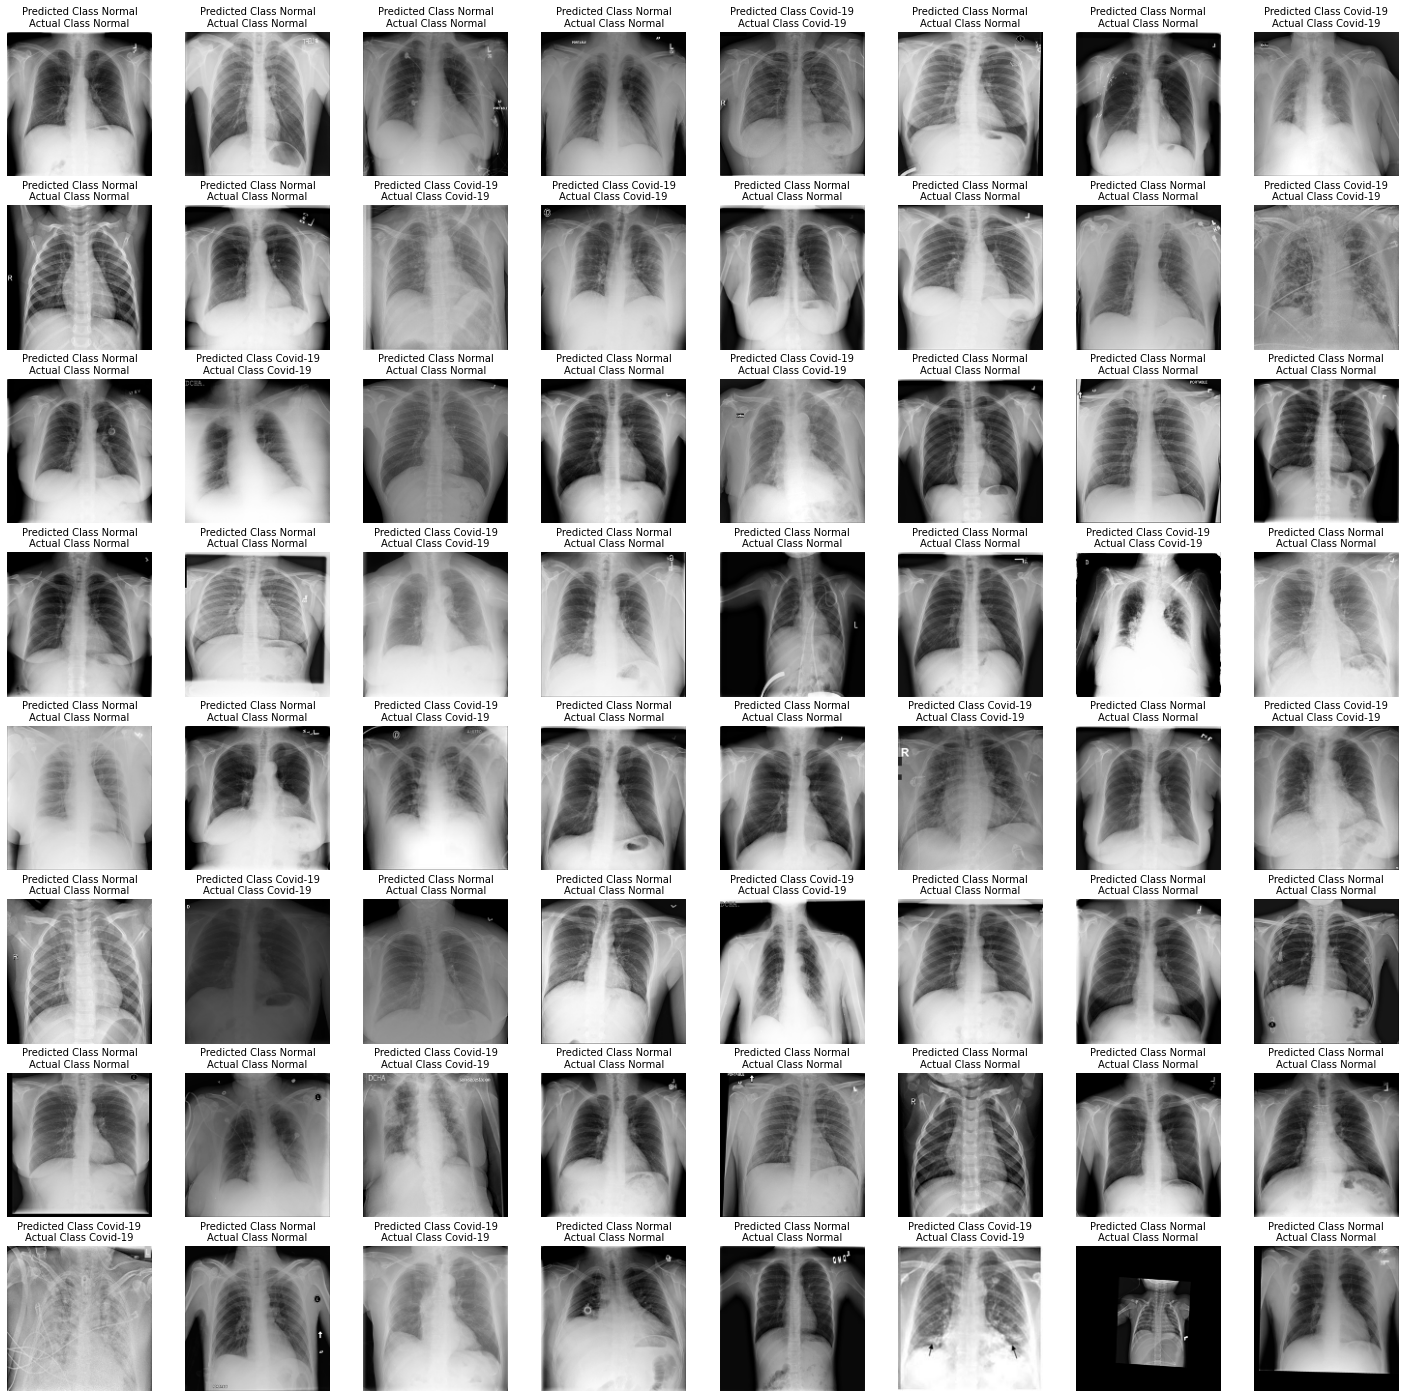

In [ ]:
correct = np.nonzero(predict == y_test)[0]
labels_actual = ['Normal' if label == 1 else 'Covid-19' for label in y_test]
labels_predict = ['Normal' if label == 1 else 'Covid-19' for label in predict]

i = 0
plt.figure(figsize=(25, 25))
for c in correct[:64]:
    plt.subplot(8,8,i+1)
    plt.imshow(X_test[c], cmap="cool")
    plt.title("Predicted Class {}\nActual Class {}".format(labels_predict[c], labels_actual[c]), fontsize=10,)
    plt.axis('off')
    i +=1

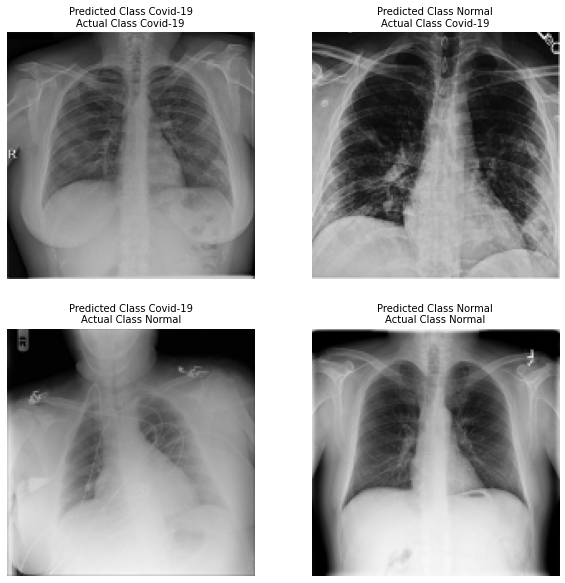

In [ ]:
tp = correct[4]
tn = correct[0]
fp = incorrect[2]
fn = incorrect[0]

labels_actual = ['Normal' if label == 1 else 'Covid-19' for label in y_test]
labels_predict = ['Normal' if label == 1 else 'Covid-19' for label in predict]

cm = [tp, fp, fn, tn]

i = 0
plt.figure(figsize=(10, 10))
for c in cm:
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[c], cmap="cool")
  plt.title("Predicted Class {}\nActual Class {}".format(labels_predict[c], labels_actual[c]), fontsize=10,)
  plt.axis('off')
  i +=1
  
plt.savefig('Sample.png')